In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
# custom modules
from agents.MemoryBuffer import MemoryBuffer
from agents.NeuralNetwork import NeuralNetwork
from sklearn.preprocessing import MinMaxScaler

from resources import Plots
from environment.Config import ConfigTimeSeries

def binaryState(timeseries, cursor, action):
    """
    :param timeseries:
    :param cursor: the position where in the TimeSeries we are currently
    :return: The Value of the current position, states with the same value are treated the same way
    """
    state = np.asarray([np.float64(timeseries['value'][cursor]), 1 if action == 1 else 0])
    return state


def binaryReward(state, timeseries, cursor, action, path=None):
    if state[1] == 1 and timeseries['anomaly'][cursor] == 1:
        if action == 1:
            return 5
        if action == 0:
            return -5
    if state[1] == 1 and timeseries['anomaly'][cursor] == 0:
        if action == 1:
            return -1
        if action == 0:
            return 1
    if state[1] == 0 and timeseries['anomaly'][cursor] == 1:
        if action == 1:
            return 5
        if action == 0:
            return -5
    if state[1] == 0 and timeseries['anomaly'][cursor] == 0:
        if action == 1:
            return -1
        if action == 0:
            return 1


C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\ten

In [2]:
class TimeSeriesEnvironment:
    def __init__(self, directory="../ts_data/",
                 config=ConfigTimeSeries(normal=0, anomaly=1, reward_correct=1, reward_incorrect=-1,
                                         action_space=[0, 1], seperator=",", boosted=False),
                 filename="Test/SmallData.csv", verbose=False,
                 scaler=MinMaxScaler(), window=False):
        """
        Initialization of one TimeSeries, should have suitable methods to prepare DataScience
        :param directory: Path to The Datasets
        :param config: Config class Object with specified Reward Settings
        :param filename: The Name of the specified TimeSeries we are working on
        :param verbose: if True, then prints __str__
        """
        self.filename = filename
        self.file = os.path.join(directory + self.filename)
        self.cfg = config
        self.sep = config.seperator
        self.boosted = config.boosted
        self.window = window
        self.scaler = scaler

        self.action_space_n = len(self.cfg.action_space)

        self.timeseries_cursor = -1
        self.timeseries_cursor_init = 0
        self.timeseries_states = []
        self.done = False

        self.statefunction = binaryState
        self.rewardfunction = binaryReward
        self.isdone = False

        self.timeseries_labeled = pd.read_csv(self.file, usecols=[1, 2], header=0, sep=self.sep,
                                              names=['value', 'anomaly'],
                                              encoding="utf-8")

        self.timeseries_unlabeled = pd.read_csv(self.file, usecols=[1], header=0, sep=self.sep,
                                                names=['value'],
                                                encoding="utf-8")

        if verbose:
            print(self.__str__())

    def __str__(self):
        """
        :return: String Representation of the TimeSeriesEnvironment Class, mainly for debug information
        """
        return "TimeSeries from: {}\n Header(labeled):\n {} \nHeader(unlabeled):\n {} \nRows:\n " \
               "{}\nMeanValue:\n {}\nMaxValue:\n {}\nMinValue:\n {}".format(
            self.filename,
            self.timeseries_labeled.head(
                3),
            self.timeseries_unlabeled.head(
                3),
            self.timeseries_labeled.shape[0],
            round(self.timeseries_labeled["value"].mean(), 2),
            round(self.timeseries_labeled["value"].max(), 2),
            round(self.timeseries_labeled["value"].min(), 2))

    # reset the environment
    def reset(self, cursor_init=0):
        self.timeseries_cursor = cursor_init
        self.done = False
        self.normalize_timeseries()
        if not self.window:
            init_state = self.statefunction(self.timeseries_cursor)
        else:
            init_state = self.statefunction(self.timeseries_labeled, self.timeseries_cursor, 0)
        return init_state

    # take a step and gain a reward
    def step(self, action):
        current_state = self.statefunction(self.timeseries_labeled, self.timeseries_cursor, action)
        reward = self.rewardfunction(current_state, self.timeseries_labeled, self.timeseries_cursor, action)
        self.update_cursor()
        next_state = self.statefunction(self.timeseries_labeled, self.timeseries_cursor, action)
        return current_state, action, reward, next_state, self.is_done(self.timeseries_cursor)

    def update_cursor(self):
        self.timeseries_cursor += 1

    def is_done(self, cursor):
        if cursor >= len(self.timeseries_labeled) - 1:
            self.done = True
            return True
        else:
            self.done = False
            return False

    def normalize_timeseries(self):
        self.timeseries_labeled["value"] = self.scaler.fit_transform(self.timeseries_labeled[["value"]])

    def isanomaly(self, cursor):
        if self.timeseries_labeled['anomaly'][cursor] == 1:
            return 1
        else:
            return 0

    def get_series(self, labelled=True):
        if labelled:
            return self.timeseries_labeled
        return self.timeseries_unlabeled

    def get_name(self):
        return self.filename

In [3]:
# Global Variables
BATCH_SIZE = 512


class BinaryDDQNAgent:
    """
    This Agent is using a Sliding Window Approach to estimate the Q(s,a) Values.
    The Sliding Window is moved over the Timeseries input to create subsequent states of it.
    The Batch Size describes how many transitions are updated with the NN function approximation at once
    """

    def __init__(self, actions, alpha, gamma, epsilon, epsilon_end, epsilon_decay):
        """
        :param actions: The amount of actions which are possible in our environment
        :param alpha: The hyperparameter for Q-Learning to choose the learning rate
        :param gamma: The hyperparameter for Q-Learning to choose the discount rate
        :param epsilon: The hyperparameter for Q-Learning to choose the exploration percentage starting point
        :param epsilon_end: The hyperparameter for Q-Learning to choose the exploration percentage end point
        :param epsilon_decay: The hyperparameter for Q-Learning to choose the exploration decay per episode
        """
        self.nA = actions
        self.batch_size = BATCH_SIZE
        self.alpha = alpha
        self.gamma = gamma
        self.memory = MemoryBuffer(max=50000, id="binary")
        # Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        # fitting param
        self.epoch_count = 2
        self.model = NeuralNetwork(2, 3).keras_model
        self.model_target = NeuralNetwork(2, 3).keras_model  # target neural network, updated every n epsiode
        self.update_target_from_model()  # update weights of target neural network
        self.hist = None  # history object can be used for tensorflow callback
        self.loss = []  # the loss array which can be used for callbacks from tensorflow

    def action(self, state):
        """
        The action function chooses according to epsilon-greedy policy actions in our environment
        :param state: The state, representing the Sliding Window of datapoints in our Timeseries
        :return: returns an action in our action space ∈ (0, 1)
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA)  # Explore Actions by percentage epsilon
        if self.epsilon == 0:  # greedy action choice for testing the agents performance in our environment
            action_vals = self.model_target.predict(np.array(state).reshape(1, 2))
        else:
            action_vals = self.model.predict(np.array(state).reshape(1,2))
        return np.argmax(action_vals)

    def experience_replay(self, batch_size):
        """
        Experience Replay is necessary for our off-policy algorithm to derive the optimal policy out of the
        Transition-Set:(state, action, reward, next_state, done) which is of size: batch_size.
        DQN: The algorithm estimates the return (total discounted future reward) for state-action pairs assuming a greedy
        policy was followed despite the fact that it's not following a greedy policy.

        :param batch_size: number of transitions to be fitted at once
        """
        # get a sample from the memory buffer
        minibatch = self.memory.get_exp(batch_size)

        # create default input arrays for the fitting of the model
        x = []
        y = []

        state_predict, nextstate_predict, nextstate_predict_target = self.predict_on_batch(minibatch)

        index = 0
        # we must iterate through the batch and calculate all target values for the models q values
        for state, action, reward, nextstate, done in minibatch:
            x.append(state)
            # Predict from state
            nextstate_action_predict_target = nextstate_predict_target[index]
            nextstate_action_predict_model = nextstate_predict[index]
            # now we calculate the target Q-Values for our input batch of transitions
            if done:  # Terminal State: Just assign reward
                target = reward
            else:  # Non terminal State: Update the Q-Values
                target = reward + self.gamma * nextstate_action_predict_target[
                    np.argmax(nextstate_action_predict_model)]  # Using Q-Value from our Target Network follows DDQN
            target_f = state_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        # Reshape for Keras Fitting Function
        x_reshape = np.array(x)
        y_reshape = np.array(y)
        self.hist = self.model.fit(x_reshape, y_reshape, epochs=self.epoch_count, verbose=0)

    def predict_on_batch(self, batch):
        """
        Helper method to get the predictions on out batch of transitions in a shape that we need
        :param batch: n batch size
        :return: NN predictions(state), NN predictions(next_state), Target NN predictions(next_state)
        """
        # Convert to numpy for speed by vectorization
        st = np.array(list(list(zip(*batch))[0]))
        nst = np.array(list(list(zip(*batch))[3]))
        # predict on the batches with the model as well as the target values
        st_predict = self.model.predict(st)
        nst_predict = self.model.predict(nst)
        nst_predict_target = self.model_target.predict(nst)

        return st_predict, nst_predict, nst_predict_target

    def update_target_from_model(self):
        """
        Update the target model from the base model
        """
        self.model_target.set_weights(self.model.get_weights())

    def anneal_eps(self):
        """
        Anneal our epsilon factor by the decay factor
        """
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

In [4]:
def build_model():
    model = keras.Sequential()  # linear stack of layers https://keras.io/models/sequential/
    model.add(
        keras.layers.Dense(24, input_dim=2,
                           activation='relu'))  # [Input] -> Layer 1
    model.add(keras.layers.Dense(24, activation='relu'))  # Layer 3 -> [output]
    model.add(keras.layers.Dense(24, activation='relu'))  # Layer 3 -> [output]
    model.add(keras.layers.Dense(2, activation='linear'))  # Layer 3 -> [output]
    model.compile(loss='mse',  # Loss function: Mean Squared Error
                  optimizer=keras.optimizers.Adam(
                      lr=0.001))  # Optimaizer: Adam (Feel free to check other options)
    return model

In [5]:
from resources import Utils as utils
from resources.Plots import plot_actions
class Simulator:
    """
    This class is used to train and to test the agent in its environment
    """

    def __init__(self, max_episodes, agent, environment, update_steps):
        """
        Initialize the Simulator with parameters

        :param max_episodes: How many episodes we want to learn, the last episode is used for evaluation
        :param agent: the agent which should be trained
        :param environment: the environment to evaluate and train in
        :param update_steps: the update steps for the Target Q-Network of the Agent
        """
        self.max_episodes = max_episodes
        self.episode = 0
        self.agent = agent
        self.env = environment
        self.update_steps = update_steps

        # information variables
        self.training_scores = []
        self.test_rewards = []
        self.test_actions = []

    def run(self):
        """
        This method is for scheduling training before testing
        :return: True if finished
        """
        while True:
            start = utils.start_timer()
            start_testing = self.__can_test()
            if not start_testing:
                info = self.__training_iteration()
                print("Training episode {} took {} seconds {}".format(self.episode, utils.get_duration(start), info))
                self.__next__()
            if start_testing:
                self.__testing_iteration()
                print("Testing episode {} took {} seconds".format(self.episode, utils.get_duration(start)))
                break
            self.agent.anneal_eps()
        plot_actions(self.test_actions[0], self.env.timeseries_labeled)
        return True

    def __training_iteration(self):
        """
        One training iteration is through the complete timeseries, maybe this needs to be changed for
        bigger timeseries datasets.

        :return: Information of the training episode, if update episode or normal episode
        """
        rewards = 0
        state = self.env.reset()
        for idx in range(len(
                self.env.timeseries_labeled)):
            action = self.agent.action(state)
            state, action, reward, nstate, done = self.env.step(action)
            rewards += reward
            self.agent.memory.store(state, action, reward, nstate, done)
            state = nstate
            if done:
                self.training_scores.append(rewards)
                break
            # Experience Replay
            if len(self.agent.memory) > self.agent.batch_size:
                self.agent.experience_replay(self.agent.batch_size)
        # Target Model Update
        if self.episode % self.update_steps == 0:
            self.agent.update_target_from_model()
            return "Update Target Model"
        return ""

    def __testing_iteration(self):
        """
        The testing iteration with greedy actions only.
        """
        rewards = 0
        actions = []
        state = self.env.reset()
        self.agent.epsilon = 0
        for idx in range(len(
                self.env.timeseries_labeled)):
            action = self.agent.action(state)
            actions.append(action)
            state, action, reward, nstate, done = self.env.step(action)
            rewards += reward
            state = nstate
            if done:
                actions.append(action)
                self.test_rewards.append(rewards)
                self.test_actions.append(actions)
                break

    def __can_test(self):
        """
        :return: True if last episode, False before
        """
        if self.episode >= self.max_episodes:
            return True
        return False

    def __next__(self):
        # increment episode counter
        self.episode += 1

In [6]:
import os
import random
import time
from collections import deque
from resources.Utils import load_object, store_object


class MemoryBuffer:
    def __init__(self, max, id):
        self.memory = deque([], maxlen=max)
        self.id = "memory_{}.obj".format(id)

    def store(self, state, action, reward, nstate, done):
        # Store the experience in memory
        self.memory.append((state, action, reward, nstate, done))

    def init_memory(self, env):
        # time measurement for memory initialization
        init_time = time.time()
        # resetting environment once
        env.reset()
        # try to load memory from local file
        if os.path.isfile(self.id):
            self.memory = load_object(self.id)
        # try to init memory by taking random steps in our environment until the deque is full
        else:
            while True:
                # break if memory is full
                if len(self.memory) >= self.memory.maxlen:
                    break
                # check if we need to reset env and still fill our memory
                if env.is_done(env.timeseries_cursor):
                    env.reset()
                # get random action
                action = random.randrange(env.action_space_n)
                # take step in env and append
                state, action, reward, nstate, done = env.step(action)
                # store our memory in class
                self.store(state, action, reward, nstate, done)
            # store our memory locally to reduce loading time on next run
            store_object(self.memory, self.id)
            print("Memory is full, {} Samples stored. It took {} seconds".format(len(self.memory),
                                                                                 time.time() - init_time))

    def get_exp(self, batch_size):
        # Popping from the Memory Queue which should be filled randomly beforehand
        return [self.memory.popleft() for _i in range(batch_size)]

    def __len__(self):
        return len(self.memory)

TimeSeries from: ./Test/SmallData.csv
 Header(labeled):
    value  anomaly
0  12183        0
1  12715        0
2  12736        0 
Header(unlabeled):
    value
0  12183
1  12715
2  12736 
Rows:
 1439
MeanValue:
 11020.08
MaxValue:
 170029
MinValue:
 3594
Successfully loaded Object from memory_binary.obj
Training episode 0 took 3.352038860321045 seconds Update Target Model
Training episode 1 took 0.20245885848999023 seconds 
Training episode 2 took 0.2234022617340088 seconds 
Training episode 3 took 0.25731611251831055 seconds 
Training episode 4 took 0.29015469551086426 seconds 
Training episode 5 took 0.301194429397583 seconds 
Training episode 6 took 0.3001976013183594 seconds 
Training episode 7 took 0.3221397399902344 seconds 
Training episode 8 took 0.31081271171569824 seconds 
Training episode 9 took 0.3482813835144043 seconds 
Training episode 10 took 0.34211277961730957 seconds Update Target Model
Training episode 11 took 0.36200714111328125 seconds 
Training episode 12 took 0.3

C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


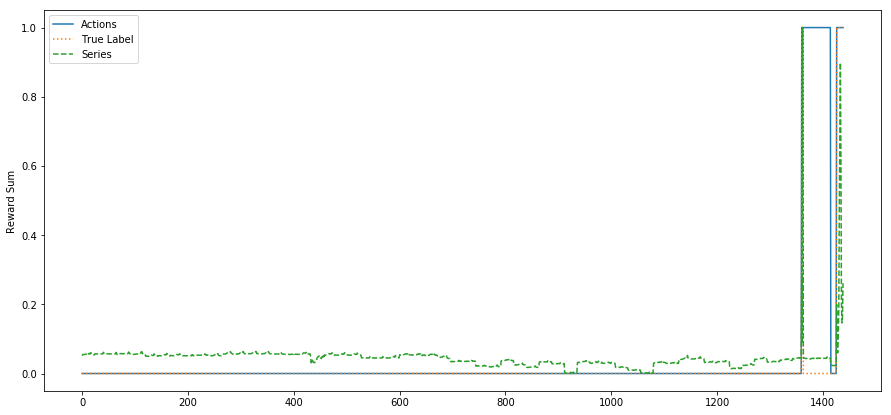

True

In [7]:

config = ConfigTimeSeries(seperator=",", window=1)
env = TimeSeriesEnvironment(verbose=True, filename="./Test/SmallData.csv", config=config, window=True)

dqn = BinaryDDQNAgent(env.action_space_n, alpha=0.0001, gamma=0.99, epsilon=1, epsilon_end=0, epsilon_decay=0.9)
simulation = Simulator(100, dqn, env, 10)
dqn.memory.init_memory(env=env)
simulation.run()